# [LAB 02] DBSCAN | 하이퍼 파라미터 튜닝

- DBSCAN 의 전반적인 프로세스
1. 스케일링
2. min_samples 고정
3. k-distance plot
4. eps 후보 선정
5. 군집 구조 + 노이즈 비율 확인
6. 도메인 해석으로 최종 결정


## #01. 준비작업
### [1] 패키지 참조

최근접이웃 시각화 -> EPS 후보 선정

한그룹당 몇개 이상 있을 떄 군집으로 취급할거니?

갑자기 멀어지는 지점

가장 가까운 거리에 이쓴 데이터-> 선그래프로 그려요




In [8]:
from hossam import load_data, my_dpi
from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

from scipy.spatial import ConvexHull

from kneed import KneeLocator

#성능평가지표
from kneed import KneeLocator

### [2] 데이터 가져오기

In [4]:
origin = load_data('game_usage')

게임 이용시간(time spent)과 레벨(game level)에 대한 가상 데이터


### [3] 데이터 전처리
- 종속변수 제거 + 데이터 표준화

In [5]:
scaler = StandardScaler()
df=DataFrame(scaler.fit_transform(origin),columns=origin.columns)
df.head()

,time spent,game level
0,-0.250733,1.474805
1,0.326494,0.606546
2,-0.611500,0.795456
3,0.470801,1.674613
4,-1.405187,-1.558652


## #02.min_samples 고정
- 즉, 몇개의 데이터가 최소한으로 모였을 때, 그걸 군집이 모였다고 평가할것인지에 대한 기준

- 실무 기준 규칙
  - 일반 데이터 : min_samples = 5~10
  - 차원 d 기준 경험적 선정 (아래 표 참고)
  
| 차원 수 | 권장 min_samples |
|--------|------------------|
| 2~3 | 3~6 |
| 5~10 | 8~15 |
| 10 이상 | 15 이상 |

- 본 예시에서는 차원수가 2 이므로 3으로 고정

In [6]:
min_samples=3

## #03.k-distance plot
### [1] k-distance plot 이해하기
#### [1] 이해하기
DBSCAN 에서 eps 를 정하기 위한 시각적 도구
각 데이터 포인트의 k 번쨰 최근접 이웃 거리 분포를 정렬해 그린 그래프

In [7]:
k=min_samples

#### [2] 핵심 아이디어
- 왜 k distance plot 이 필요한가?
   (1) DBSCAN 은 eps 에 매우 민감
   (2) 수치만 보고 eps 정하면 실패 확률 높음
   (3) 거리 분포를 직접 보면 데이터 밀도 구조가 보임


#### [3] 계산 절차
1. k 개의 최근접 이웃 만들기
   - k=min_samples 설정
   - 각 점에 대해 k 번째 최근접 이웃 거리 계산
   - 모든 점의 거리 값이 가까운 순서대로 정렬 (오름차순)
2. 그래프에서 꺾이는 지점 확인 (Elbow point)
   - x 축 : 데이터의 인덱스 / y 축 : k-distance
  
| 구간 | 의미 |
|------|------|
| 완만한 구간 | 고밀도 영역(군집 내부) |
| 급격한 상승 지점 | 저밀도 영역 시작 |
| 꺾이는 지점 (elbow) | 적절한 eps 후보 |




#### [4] 실무에서의 한계점
- k distancep lot 은 eps 를 보면서 정해야함
  
| 한계 | 설명 |
|------|------|
| 주관성 | elbow 판단이 사람마다 다름 |
| 고차원 취약 | 거리 집중 현상 발생 |
| 자동화 어려움 | 명확한 수식 기준 없음 |



### [2] k 개의 최근접 이웃 만들기
- k-distance plot 을 만들기 위한 로직
- taget 은, 각 데이터 포인트에서, k 번째로 가까운 이웃까지의 거리를 전부 모아서 정렬한 것
- 이를 토대로 eps 를 찾는것이 목적

In [ ]:
# k = min_samples 설정
k=min_samples


#각 점에 대해 k 번쨰 최근접 이웃 거리 계산
neighbors = NearestNeighbors (n_neighbors=k)
neighbors_fit = neighbors.fit(df)

#이떄 distance 는 각 데이터 포인트가 k 번째까지의 포인트와의 거리를 가까운 순서대로 리스트로 가지고 있음
distance ,indices = neighbors_fit.kneighbors(df)


#모든 점의 거리 값을 가까운 순서대로 정렬 (오름차순)
s_distance = np.sort(distance,axis=0)


#각 데이터 포인트로부터의 거리 추출
target = s_distance[:,k-1]  #k 번째 이웃은 k-1 번쨰 이웃에 존재 , 즉 가장 멀리 있는 값을 가져와서 최소 반경 설정
target


array([0.10111015, 0.11039822, 0.11625223, 0.11988511, 0.12172144,
       0.12285113, 0.12769295, 0.12769295, 0.12836733, 0.12836733,
       0.12836733, 0.14619664, 0.14620339, 0.14936701, 0.14972662,
       0.14972662, 0.15325497, 0.15557345, 0.15678809, 0.15678809,
       0.15843153, 0.1588343 , 0.16323203, 0.16697634, 0.16697634,
       0.17807115, 0.17867241, 0.17867241, 0.1803835 , 0.18096788,
       0.18305073, 0.18332275, 0.18890987, 0.18890987, 0.19313888,
       0.19721127, 0.20223342, 0.2034414 , 0.2034414 , 0.21075165,
       0.21265306, 0.2164602 , 0.21735497, 0.21735497, 0.21840257,
       0.21891561, 0.22011805, 0.22405052, 0.22412868, 0.22412868,
       0.2293733 , 0.23202731, 0.23336017, 0.23997564, 0.24073719,
       0.24336383, 0.25066886, 0.25104255, 0.25735751, 0.25735751,
       0.26275573, 0.26444959, 0.26650157, 0.268372  , 0.27569735,
       0.27651041, 0.28918464, 0.28923923, 0.29007322, 0.29212993,
       0.29212993, 0.29240678, 0.29286115, 0.30298035, 0.31153

### [3] 그래프에서 꺾이는 지점 확인 (Elbow Point)
#### (1) EPS 값 찾기 = elbow point

In [ ]:

#값이 증가하면서, 아래로 볼록한 형태의 곡선에서 꺾이는 지점을 찾아야함
kl = KneeLocator(range(0,len(target)),target,curve='convex',direction='increasing')
eps = kl.elbow_y
point=kl.elbow
print('found elbow:',eps)
print('found point:',point)

found elbow: 0.41251429498079606
found point: 91


#### [2] 시각화

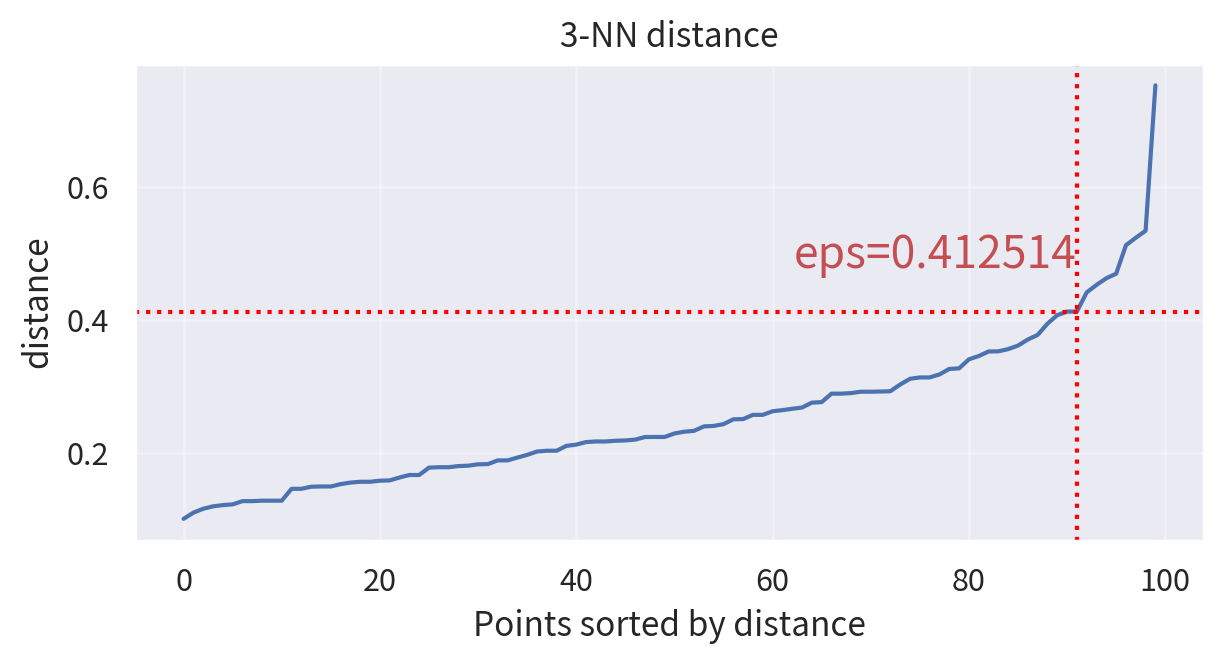

In [16]:
# 1) 그래프 초기화
width_px = 1280              # 그래프 가로 크기
height_px = 720              # 그래프 세로 크기
rows = 1                     # 그래프 행 수
cols = 1                     # 그래프 열 수
my_dpi=200

figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) Line Plot 그리기
sb.lineplot(x=range(0,len(target)),y=target)


#엘보우 포인트 표시
ax.axvline(x=point,color='red',linestyle=':')
ax.axhline(y=eps,color='red',linestyle=':')

ax.text(point,eps+0.05,'eps=%f' %eps,fontsize=16,color='r',va='bottom',ha='right')



ax.set_title("%d-NN distance" % k)
ax.set_ylabel("distance")
ax.set_xlabel("Points sorted by distance")
ax.grid(True, alpha=0.3)

# 3) 그래프 꾸미기
ax.grid(True)                 # 배경 격자 표시/숨김

# 4) 출력
plt.tight_layout()            # 여백 제거
plt.show()                    # 그래프 화면 출력
plt.close()                   # 그래프 작업 종료


### #04 도출된 eps 와 k 값을 활용한 군집
#### [1] 군집 모형 적합

In [17]:
estimator = DBSCAN(eps =eps,min_samples=k,n_jobs=-1)
estimator.fit(df)

result_df =df.copy()
result_df['cluster'] = estimator.labels_
result_df.head()

,time spent,game level,cluster
0,-0.250733,1.474805,0
1,0.326494,0.606546,0
2,-0.611500,0.795456,0
3,0.470801,1.674613,1
4,-1.405187,-1.558652,2


#### [2] 벡터 종류 구분

In [18]:
result_df2 = result_df.copy()

#기본적으로 모두 외곽 벡터로 지정
result_df2['vector'] = 'border'

#핵심 벡터인 경우 'core' 로 지정
result_df2.loc[estimator.core_sample_indices_,'vector'] = 'core'

#노이즈 분류
result_df2.loc[result_df2['cluster'] == -1 , 'vector']='noise'

result_df2.head()


,time spent,game level,cluster,vector
0,-0.250733,1.474805,0,core
1,0.326494,0.606546,0,core
2,-0.611500,0.795456,0,core
3,0.470801,1.674613,1,core
4,-1.405187,-1.558652,2,core


#### [3] 시각화

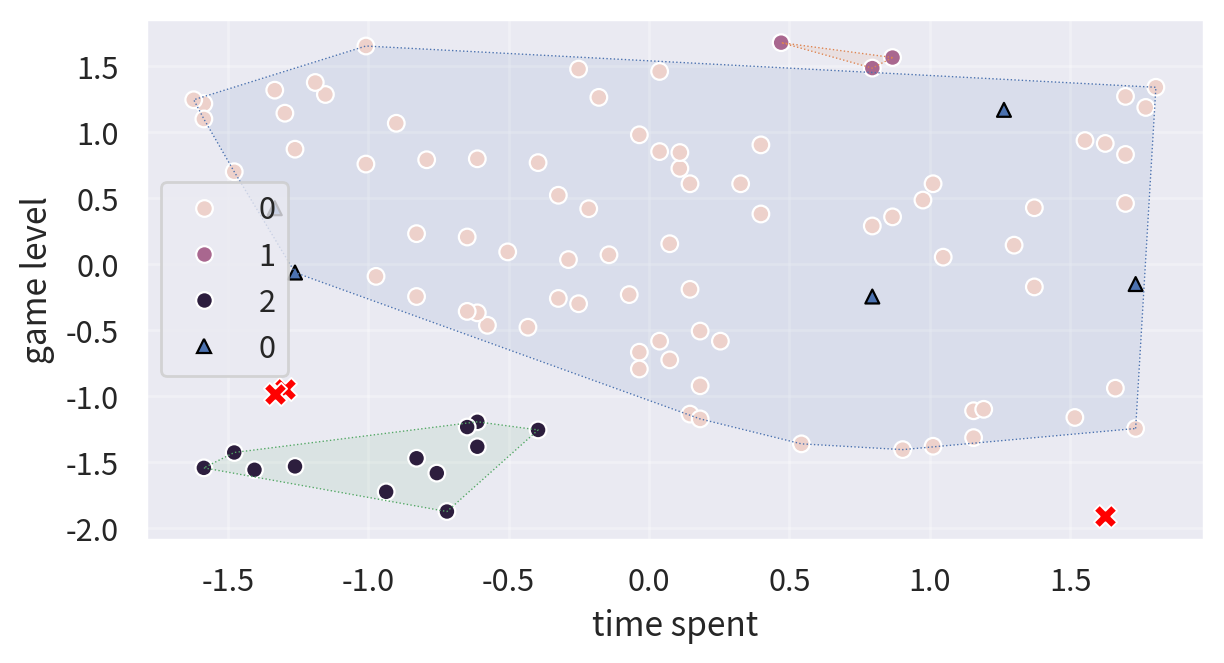

In [19]:
vdf = result_df2.copy()
hue_field ='cluster'
x_field = 'time spent'   
y_field = 'game level'

# 1) 그래프 초기화
width_px = 1280              # 그래프 가로 크기
height_px = 720              # 그래프 세로 크기
rows = 1                     # 그래프 행 수
cols = 1                     # 그래프 열 수
my_dpi=200

figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)


# 군집별 값의 종류별로 반복문 실행
for c in vdf[hue_field].unique():

#이상치는 건너뜀
  if c == -1:
    continue

  #값의 종류별로 데이터 프레임 구분
  df_c = vdf.loc[vdf[hue_field] == c , [x_field,y_field]]

  try:
    #외각선 좌표 계산
    hull = ConvexHull(df_c)

    #마지막 좌표 이후에 첫번쨰 좌표를 연결
    points = np.append(hull.vertices,hull.vertices[0])

    ax.plot( #type:ignore
      df_c.iloc[points,0] , df_c.iloc[points,1] , linewidth = 0.5 , linestyle =':'
      )
    
    ax.fill(df_c.iloc[points,0] , df_c.iloc[points ,1], alpha =0.1)


  except:
    pass


# 핵심 벡터만 표시
sb.scatterplot(
  data = vdf[(vdf[hue_field] !=-1)  & (vdf['vector'] =='core')],
  x=x_field,
  y=y_field,
  hue='cluster',
  edgecolor='white',
  linewidth=0.8

)


# 외곽 벡터만 표시
sb.scatterplot(
  data = vdf[(vdf[hue_field] !=-1)  & (vdf['vector'] =='border')],
  x=x_field,
  y=y_field,
  hue='cluster',
  marker ='^',
  s=25,
  edgecolor='#000',
  linewidth=0.8

)



# 노이즈 벡터만 표시
sb.scatterplot(
  data = vdf[vdf['vector'] =='noise'],
  x=x_field,
  y=y_field,
  color ='red',
  marker = 'X',
  s=70
)

ax.grid(True ,alpha =0.3) #배경 격자 표시
plt.tight_layout()
plt.show()
plt.close()

#### 인사이트
- 0번 그룹 : 게임을 잘 하지 않는 사용자  
- 1번 그룹 : 게임을 잘하는 사용자  
- 2번 그룹 : 게임에 집착하는 사용자  
- X : 이상치(비정상 사용자)

DBSCAN은 그 자체로 최종적인 군집 결과를 얻기보다는,  
**EDA 초반 단계에서 이상치를 분리·탐지하기 위한 목적**
